In [1]:
from __future__ import print_function, division
import os
import sys

import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv, find_dotenv
%matplotlib inline

print('sys_version', sys.version.replace('\n', ''))
print('virtual_env', os.environ.get('VIRTUAL_ENV', 'None'))
print('pwd', os.getcwd())
print('np ', np.__version__)
print('pd ', pd.__version__)

logging.getLogger().setLevel(logging.INFO)
load_dotenv(find_dotenv())

sys_version 3.5.2 (default, Nov 17 2016, 17:05:23) [GCC 5.4.0 20160609]
virtual_env None
pwd /home/marko/nmiculinic/minion/notebook
np  1.12.1
pd  0.20.1


/usr/local/lib/python3.5/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/lib/python3.5/dist-packages/dotenv/main.py:24: UserWarning: Not loading  - it doesn't exist.
  warnings.warn("Not loading %s - it doesn't exist." % dotenv_path)


## Align with graphmap

### Merge .fa files into single .fa

In [2]:
from mincall.align_utils import merge_reads, cnt_sequences_in_fastx

reads_root_dir = '/data/fastas/'
single_reads_file = '/data/fastas/total/all.fa'

merge_reads(reads_root_dir, single_reads_file)

### define reference

In [3]:
ref_path = '/data/references/NC_001416.fa'
is_circular = True

### run graphmap

In [4]:
from mincall.align_utils import align_with_graphmap

out_sam_path = '/data/sams/lambda.sam'
align_with_graphmap(single_reads_file, ref_path, is_circular, out_sam_path)

INFO:root:Graphmap exit status 0


### run bwa mem

- no extended cigar option by default

In [5]:
from mincall.align_utils import align_with_bwa_mem

out_sam_path = '/data/sams/lambda_bwa.sam'
align_with_bwa_mem(single_reads_file, ref_path, is_circular, out_sam_path)

INFO:root:bwa mem align exit status 0
20reads [00:00, 98.44reads/s] WARNING:root:read Andrej_HC_20160706_FNFAD12873_MN17271_sequencing_run_lambda_R9_6_7_16_21932_ch299_read971_strand is unmapped, copy to out sam as is
100reads [00:00, 109.03reads/s]


In [6]:
sam_path = '/data/sams/lambda.sam'

## Example how to filter reads in sam

In [9]:
from mincall.align_utils import filter_aligments_in_sam, read_len_filter, secondary_aligments_filter, only_mapped_filter, supplementary_aligments_filter

# out path
sam_path = '/data/sams/all_reads.sam'
filtered_path = '/data/sams/filtered.sam'

def dummy_filter():
    def _filter(x):
        return True
    return _filter

# define list of filters (functions that take pysam.AlignedSegment and return boolean)
filters = [
    #read_len_filter(max_len=400),# read_len_filter(max_len=400),
    only_mapped_filter(), #secondary_aligments_filter(), supplementary_aligments_filter(),
    dummy_filter()
]

n_kept, n_discarded = filter_aligments_in_sam(sam_path, filtered_path, filters)
print("Kept %d, discarded %d" % (n_kept, n_discarded))

Kept 85, discarded 1


In [10]:
sam_path = filtered_path

## Error rates

In [11]:
from mincall.bioinf_utils import error_rates_for_sam

df = error_rates_for_sam(sam_path)
df.describe(percentiles=[]).transpose()


85read [00:00, 458.51read/s]


,count,mean,std,min,50%,max
Error rate,85.0,0.303575,0.121899,0.150568,0.248053,0.581709
Match rate,85.0,0.870113,0.050690,0.649657,0.890566,0.934659
Mismatch rate,85.0,0.094832,0.036100,0.039773,0.076032,0.212490
Insertion rate,85.0,0.035054,0.019210,0.014881,0.032113,0.137852
Deletion rate,85.0,0.173688,0.083177,0.065269,0.147931,0.385950
Read length,85.0,5094.635294,2582.182566,360.000000,5171.000000,11302.000000


## CIGAR operations - position analysis

In [12]:
from mincall.bioinf_utils import error_positions_report

position_report = error_positions_report(sam_path, n_buckets=100)
position_report.head()

,relative_position,operation,op_count
0,0.0,X,624
1,0.0,I,602
2,0.0,S,569
3,0.0,D,287
4,0.0,=,3021


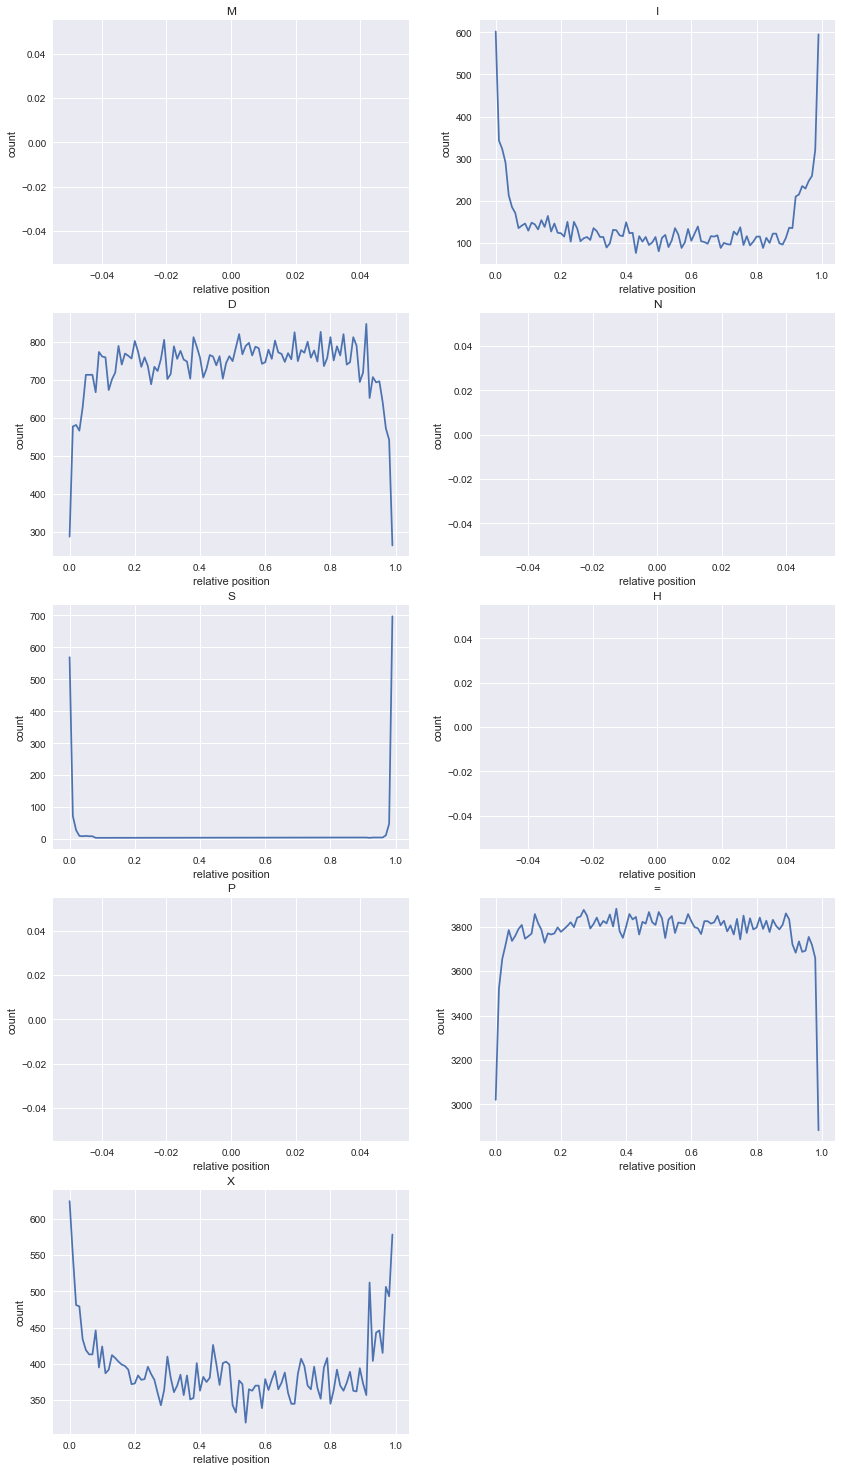

In [13]:
from mincall.bioinf_utils import CIGAR_OPERATIONS

plt.figure(figsize=(14,26))

n_graphs = len(CIGAR_OPERATIONS)
n_cols = 2
n_rows = np.ceil(n_graphs/2)


for i, op in enumerate(CIGAR_OPERATIONS):
    data = position_report[position_report.operation == op]

    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(data.relative_position, data.op_count)

    plt.xlabel('relative position')
    plt.ylabel('count')
    plt.title(op)

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6097: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 0 x 1)
  '(shape is %d x %d)' % inp.shape[::-1])


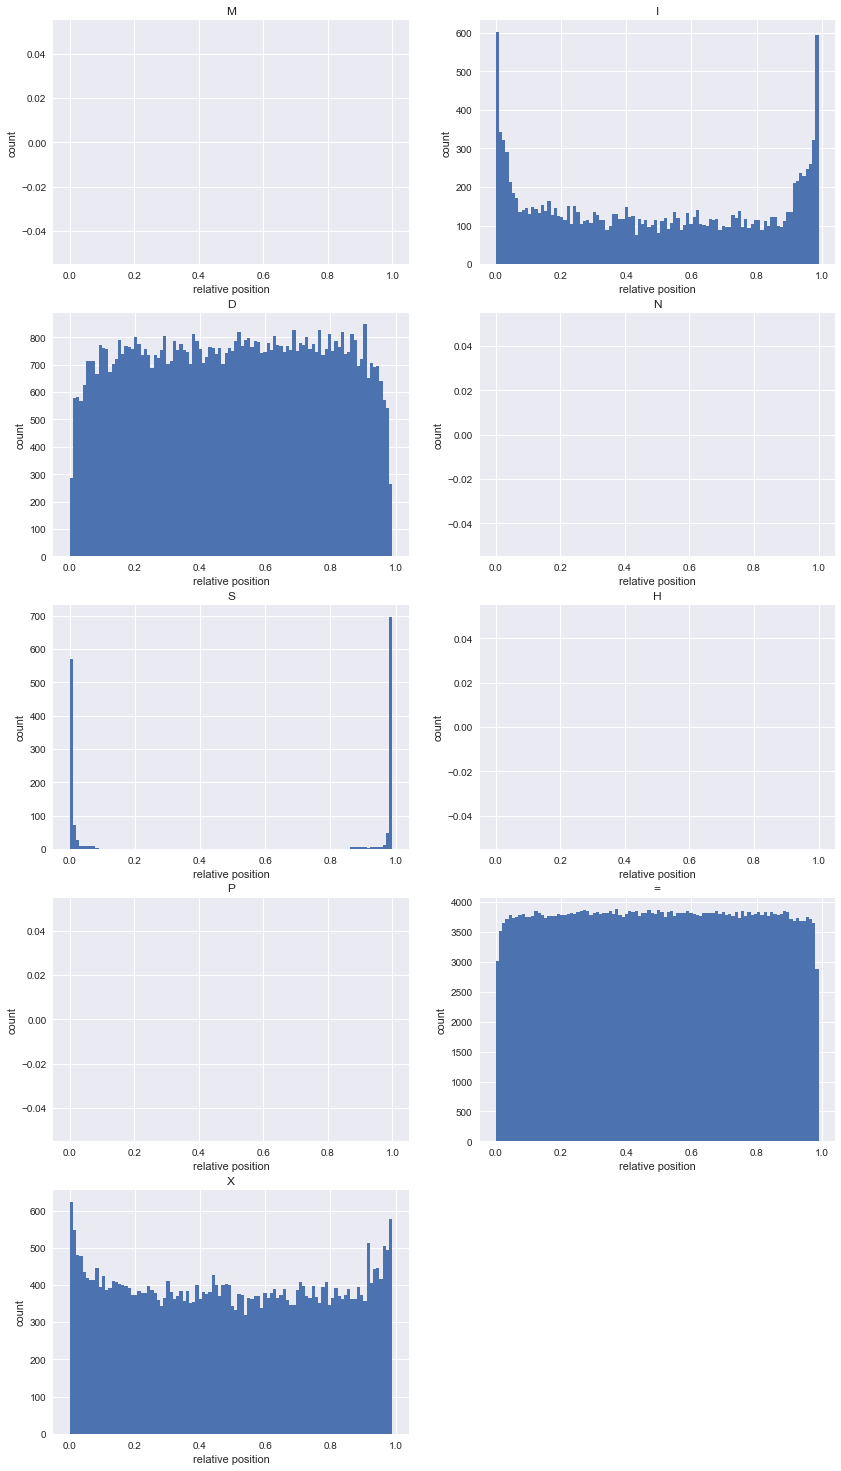

In [14]:
from mincall.bioinf_utils import CIGAR_OPERATIONS

plt.figure(figsize=(14,26))

n_graphs = len(CIGAR_OPERATIONS)
n_cols = 2
n_rows = np.ceil(n_graphs/2)


for i, op in enumerate(CIGAR_OPERATIONS):
    data = position_report[position_report.operation == op]

    plt.subplot(n_rows, n_cols, i+1)
    plt.hist(data.relative_position, bins=100, weights=data.op_count)
    #plt.plot(data.relative_position, data.op_count)


    plt.xlabel('relative position')
    plt.ylabel('count')
    plt.title(op)


## Consensus stats

In [15]:
from mincall.consensus import get_consensus_report


import importlib
from mincall import consensus
importlib.reload(consensus)
from mincall import consensus
from mincall.consensus import get_consensus_report


In [16]:
sam_path

'/data/sams/filtered.sam'

In [17]:
report_out_dir = '/data/reports/' #dir for vcf and csv files
tmp_files_dir = '/data/reports/tmp' #tmp dir for bam, bai and mpilup files
coverage_threshold = 0

# Arguments for storing detailed data
#report = get_consensus_report('mincall', sam_path, ref_path, is_circular, coverage_threshold, report_out_dir, tmp_files_dir)
report = get_consensus_report('mincall', sam_path, ref_path, is_circular, coverage_threshold)

INFO:root:Split long aligments
85it [00:00, 1642.29it/s]
INFO:root:Converting sam to bam
INFO:root:Sorting bam file
INFO:root:Creating bam index
INFO:root:Creating mpileup
INFO:root:Generating consensus and report
100%|██████████| 48534/48534 [00:02<00:00, 20433.89it/s]
INFO:root:Cleaning tmp files


In [18]:
report.transpose()

,mincall
alignments_file,/data/sams/filtered.sam
mpileup_file,/tmp/tmpt74i5a_s/filtered.bam.bam.mpilup
coverage_threshold,0
snp_count,234
insertion_count,6
deletion_count,162
num_undercovered_bases,0
num_called_bases,48346
num_correct_bases,48106
average_coverage,10.0792


In [116]:
import pysam
import pandas as pd


def load_vcf_file(vcf_path):
    data = []
    with pysam.VariantFile(vcf_path, 'r') as vcf_in:
        for rec in vcf_in.fetch():
            old, new = rec.alleles
            data.append([rec.pos, rec.info['TYPE'][0], old, new, rec.info['DP']])

    df = pd.DataFrame(data, columns=['pos', 'type', 'from_bases', 'to_bases', 'coverage']) 
    df.set_index('pos', inplace=True)
    return df
    
vcf_path = '/data/reports/cov_0.variant.vcf'
vcf_stats = load_vcf_file(vcf_path)
vcf_stats.head()

,type,from_bases,to_bases,coverage
pos,,,,
137,del,AG,A,11
565,snp,T,C,12
819,snp,A,G,12
1174,snp,G,A,12
1689,del,TG,T,11
